**Dataset**
labeled datasset collected from twitter (Lab 1 - Hate Speech.tsv)

**Objective**
classify tweets containing hate speech from other tweets. <br>
0 -> no hate speech <br>
1 -> contains hate speech <br>

**Total Estimated Time = 90-120 Mins**

**Evaluation metric**
macro f1 score

### Import used libraries

In [1]:
import pandas as pd 
import numpy as np 
import nltk
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
import string
import contractions 
from sklearn.model_selection import train_test_split 
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressiona
from sklearn.metrics import f1_score, classification_report

In [2]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True) 

True

### Load Dataset

###### Note: search how to load the data from tsv file

In [3]:
data = pd.read_csv('Lab 1 - Hate Speech.tsv' , sep='\t')

In [4]:
pd.set_option('display.max_rows' , 500)
pd.set_option('display.max_colwidth' ,500)
data.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,10,0,@user @user welcome here ! i'm it's so #gr8 !


In [5]:
X = data['tweet']
y = data['label']

### Data splitting

It is a good practice to split the data before EDA helps maintain the integrity of the machine learning process, prevents data leakage, simulates real-world scenarios more accurately, and ensures reliable model performance evaluation on unseen data.

In [6]:
X_train , X_test , y_train , y_test = train_test_split(X,y)

### EDA on training data

- check NaNs

In [7]:
data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

- check duplicates

In [8]:
data.duplicated().value_counts()

False    31535
Name: count, dtype: int64

In [9]:
data.drop_duplicates(inplace= True)

- show a representative sample of data texts to find out required preprocessing steps

In [10]:
data.drop('id',axis=1 , inplace = True)

In [11]:
X_train[np.random.randint(0,len(X_train))]

'sequoia is   about the #weekend!'

- check dataset balancing

In [12]:
data['label'].value_counts()

label
0    29322
1     2213
Name: count, dtype: int64

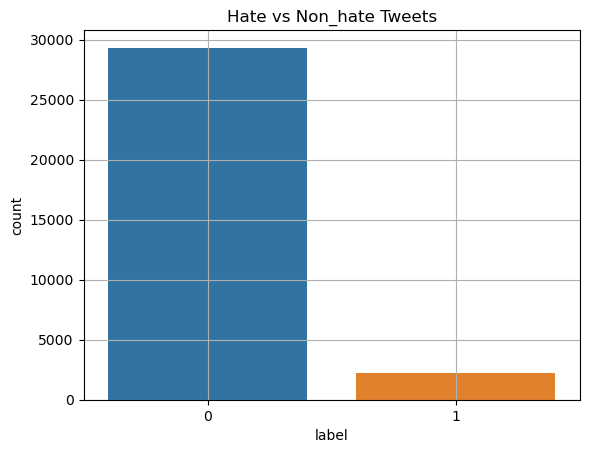

In [13]:
sns.countplot(data , x = 'label')
plt.title('Hate vs Non_hate Tweets')
plt.grid()
plt.show();

### Cleaning and Preprocessing

#### Extra: use custom scikit-learn Transformers

Using custom transformers in scikit-learn provides flexibility, reusability, and control over the data transformation process, allowing you to seamlessly integrate with scikit-learn's pipelines, enabling you to combine multiple preprocessing steps and modeling into a single workflow. This makes your code more modular, readable, and easier to maintain.

##### link: https://www.andrewvillazon.com/custom-scikit-learn-transformers/

#### Example usage:

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomTransformer(BaseEstimator, TransformerMixin):
    '''
    custom transformer for preprocessing the data 
    1.lowercase the text 
    2.remove URLs , hashtags , (@user)
    3.remove punctuation and stop words 
    4.Normalize text using Worldlemmetizer
    '''
    def __init__(self):
        self.stop_words = set(nltk.corpus.stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        
        # Add any initialization code here
    
    def fit(self, X, y=None):
        # Add code for fitting the transformer here
        return self
    
    def transform(self, X):
        # Add code for transforming the data here
        transformed_X = X.copy()
        transformed_X = transformed_X.apply(self.preprocess)
        return transformed_X
    
    def preprocess(self, text):
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'@\w+', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        tokens = nltk.word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in self.stop_words]
        preprocessed_text = ' '.join(tokens)
        return preprocessed_text
    
    def fit_transform(self, X, y=None):
        # This function combines fit and transform
        self.fit(X, y)
        return self.transform(X)

**You  are doing Great so far!**

### Modelling

#### Extra: use scikit-learn pipline

##### link: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

Using pipelines in scikit-learn promotes better code organization, reproducibility, and efficiency in machine learning workflows.

#### Example usage:

In [15]:
from sklearn.pipeline import Pipeline

model = LogisticRegression()

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessing', CustomTransformer()),
    ('Vectorizing', TfidfVectorizer()),
    ('model', model),
])

# Now you can use the pipeline for training and prediction
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

#### Evaluation

**Evaluation metric:**
macro f1 score

Macro F1 score is a useful metric in scenarios where you want to evaluate the overall performance of a multi-class classification model, **particularly when the classes are imbalanced**

![Calculation](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/639c3d934e82c1195cdf3c60_macro-f1.webp)

In [16]:
macro_f1 = f1_score(y_test, y_pred, average='macro')
macro_f1

0.6570985101451052

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7320
           1       0.88      0.21      0.34       564

    accuracy                           0.94      7884
   macro avg       0.91      0.61      0.66      7884
weighted avg       0.94      0.94      0.92      7884



### Enhancement

- Using different N-grams
- Using different text representation technique
- Hyperparameter tuning

In [18]:
pipeline = Pipeline(steps=[
    ('preprocessing', CustomTransformer()),
    ('Vectorizing', TfidfVectorizer(ngram_range=(1,2))),
    ('model', model),
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [19]:
macro_f1 = f1_score(y_test, y_pred, average='macro')
macro_f1 

0.6504559712019986

In [20]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7320
           1       0.86      0.21      0.33       564

    accuracy                           0.94      7884
   macro avg       0.90      0.60      0.65      7884
weighted avg       0.94      0.94      0.92      7884



In [21]:
pipeline = Pipeline(steps=[
    ('preprocessing', CustomTransformer()),
    ('Vectorizing', TfidfVectorizer(ngram_range=(1,3))),
    ('model', model),
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [22]:
macro_f1 = f1_score(y_test, y_pred, average='macro') 
macro_f1 

0.6417941006415281

In [23]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7320
           1       0.85      0.19      0.32       564

    accuracy                           0.94      7884
   macro avg       0.90      0.60      0.64      7884
weighted avg       0.93      0.94      0.92      7884



## another trial using Bag of words technique

In [24]:
pipeline = Pipeline(steps=[
    ('preprocessing', CustomTransformer()),
    ('vectorizer', CountVectorizer(ngram_range=(1, 2))), 
    ('model', model),
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [25]:
macro_f1 = f1_score(y_test, y_pred, average='macro')
macro_f1

0.7688227886903383

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7320
           1       0.90      0.41      0.56       564

    accuracy                           0.95      7884
   macro avg       0.93      0.70      0.77      7884
weighted avg       0.95      0.95      0.95      7884



## another trial using different N_grams 

In [27]:
pipeline = Pipeline(steps=[
    ('preprocessing', CustomTransformer()),
    ('vectorizer', CountVectorizer(ngram_range=(1, 3 ))), 
    ('model', model),
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [28]:
macro_f1 = f1_score(y_test, y_pred, average='macro')
macro_f1 

0.7738350958360872

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7320
           1       0.92      0.41      0.57       564

    accuracy                           0.96      7884
   macro avg       0.94      0.71      0.77      7884
weighted avg       0.95      0.96      0.95      7884



### Conclusion and final results


it's obvious that using bag of words with different N_grams gave me better performance 

#### Done!